In [484]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from skimage.measure import marching_cubes
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib widget


In [495]:
a = 1.0
b = 1.0
c = 1.0
n_x = 0
n_y = 0
n_z = 0

# Read the data from the file
data = []
atoms = []
with open('viability.dat', 'r') as file:
    for line in file:
        # if line starts with #grid, read the three values as n_x, n_y, n_z
        if line.startswith("#grid"):
            values = line.strip().split()
            n_x = int(values[1])
            n_y = int(values[2])
            n_z = int(values[3])
            continue
        # if line starts with #lat, read the three values as a, b, c
        if line.startswith("#lat"):
            values = line.strip().split()
            a = float(values[1])
            b = float(values[2])
            c = float(values[3])
            continue
        values = line.strip().split()
        if len(values) == 3:
            atoms.append([float(values[0]), float(values[1]), float(values[2])])
        if len(values) == 4:
            data.append([float(values[0]), float(values[1]), float(values[2]), float(values[3])])


# Extract the coordinates and values
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data])
z = np.array([row[2] for row in data])
values = np.array([row[3] for row in data])
values = values*100

# scale the data positions
x = x * a
y = y * b
z = z * c

# scale atom locations
atoms = np.array(atoms)
atoms[:,0] = atoms[:,0] * a
atoms[:,1] = atoms[:,1] * b
atoms[:,2] = atoms[:,2] * c


In [496]:
# Create a 3D grid
grid_x, grid_y, grid_z = np.mgrid[x.min():x.max():complex(n_x), y.min():y.max():complex(n_y), z.min():z.max():complex(n_z)]


In [497]:
# Interpolate data onto the 3D grid
grid_values = griddata((x, y, z), values, (grid_x, grid_y, grid_z), method='nearest')
grid_values = np.nan_to_num(grid_values)

In [488]:

# Apply Gaussian filter for smoothing
grid_values = gaussian_filter(grid_values, sigma=1)  # Adjust sigma for more or less smoothing


In [498]:
# Function to plot atoms as spheres
def plot_atoms_as_spheres(ax, atoms, radius=0.5, resolution=(10, 5)):
    u = np.linspace(0, 2 * np.pi, resolution[0])
    v = np.linspace(0, np.pi, resolution[1])
    for atom in atoms:
        atom_x, atom_y, atom_z = atom
        # Generate sphere coordinates
        x_sphere = atom_x + radius * np.outer(np.cos(u), np.sin(v))
        y_sphere = atom_y + radius * np.outer(np.sin(u), np.sin(v))
        z_sphere = atom_z + radius * np.outer(np.ones(np.size(u)), np.cos(v))
        # Plot spheres with lower resolution
        ax.plot_surface(x_sphere, y_sphere, z_sphere, color='red', alpha=1.0, rstride=1, cstride=1)
        
def plot_atoms_as_scatter(ax, atoms, size=100, color='red'):
    ax.scatter(atoms[:,0], atoms[:,1], atoms[:,2], s=size, c=color, alpha=1.0)


In [505]:
# Define the plotting function
def plot_3d_heatmap(slice_level, axis):
    ax.cla()  # Clear the plot

    # Normalise slice level to the grid range
    if axis == 'z':
        slice_idx = int(slice_level * n_z)
        slice_data = grid_values[:, :, slice_idx]
        slice_pos = (grid_x[:, :, slice_idx], grid_y[:, :, slice_idx], grid_z[:, :, slice_idx])
    elif axis == 'y':
        slice_idx = int(slice_level * n_y)
        slice_data = grid_values[:, slice_idx, :]
        slice_pos = (grid_x[:, slice_idx, :], grid_y[:, slice_idx, :], grid_z[:, slice_idx, :])
    elif axis == 'x':
        slice_idx = int(slice_level * n_x)
        slice_data = grid_values[slice_idx, :, :]
        slice_pos = (grid_x[slice_idx, :, :], grid_y[slice_idx, :, :], grid_z[slice_idx, :, :])
    elif axis == 'xy':
        # get diagonal list of idx
        slice_idx_xy = [
            ( 
                round( ( -0.5 + slice_level ) * (n_x + 1) ) + i,
                round( ( -0.5 + slice_level ) * (n_y + 1) ) + j
            ) for i, j in zip(range(n_x,-1,-1), range(n_y+1))
            if ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) < n_x and
            ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) < n_y
        ]
        slice_idx_x = [ i for i, j in slice_idx_xy ]
        slice_idx_y = [ j for i, j in slice_idx_xy ]
        slice_data = grid_values[slice_idx_x, slice_idx_y, :]
        slice_pos = (grid_x[slice_idx_x, slice_idx_y, :], grid_y[slice_idx_x, slice_idx_y, :], grid_z[slice_idx_x, slice_idx_y, :])

    # Plot heatmap on the selected slice plane
    max_val = grid_values.max()
    if max_val == 0:
        max_val = 1
    img = ax.plot_surface(slice_pos[0], slice_pos[1], slice_pos[2],
                          facecolors=plt.cm.viridis(slice_data / max_val),
                          rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False, alpha=0.8,
    )

    # Plot atoms as spheres
    plot_atoms_as_spheres(ax, atoms)
    # plot_atoms_as_scatter(ax, atoms, 200, 'red')
    
    # Set axis limits
    ax.set_xlim([0, a])
    ax.set_ylim([0, b])
    ax.set_zlim([0, c])
    
    # Labels and view adjustments
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(30, 45)
    plt.draw()


In [506]:
# Set up interactive sliders
slice_slider = widgets.FloatSlider(value=0.5, min=0, max=1-0.01, step=0.01, description='Slice Position:')
axis_selector = widgets.RadioButtons(options=['x', 'y', 'z', 'xy'], description='Axis:', value='z')


interactive(children=(FloatSlider(value=0.5, description='Slice Position:', max=0.99, step=0.01), RadioButtons…

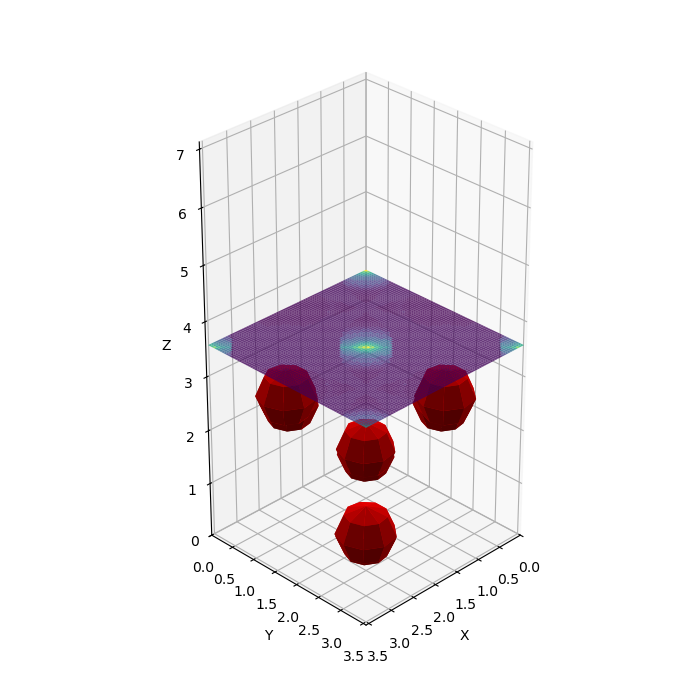

In [508]:
# Create the figure and axis
fig = plt.figure(figsize=(7, 7));
ax = fig.add_subplot(111, projection='3d');

# Set the aspect ratio based on the lattice parameters
ax.set_box_aspect([a, b, c])  # This scales the plot according to lattice ratios

# Set up interactive plot
interactive_plot = interactive(plot_3d_heatmap, slice_level=slice_slider, axis=axis_selector)
output = interactive_plot.children[-1]
interactive_plot

In [493]:
slice_level = 0.5
x = [
    ( 
        round( ( -0.5 + slice_level ) * (n_x + 1) ) + i,
        round( ( -0.5 + slice_level ) * (n_y + 1) ) + j
    ) for i, j in zip(range(n_x,-1,-1), range(n_y+1))
   if ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) < n_x and
      ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) < n_y
]

In [494]:
slice_idx_x = [ i for i, j in x ]
slice_idx_y = [ j for i, j in x ]
print(slice_idx_x)
print(slice_idx_y)

[70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
